This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles and a lot of edits made by Matthew Kehoe.

This notebook was generated for TensorFlow 2.6.

## Chapter 12: Generative deep learning

Previously, we concentrated on

*   Text generation: how recurrent neural networks can be used to generate
sequence data.  
*   DeepDream:   an  artistic  image-modification  technique  that  uses  the  representations learned by convolutional neural networks.

Now we will look at neural style transfer.

## Neural style transfer

In  addition  to  DeepDream,  another  major  development  in  deep-learning-driven image modification is <font color='blue'>neural style transfer</font>, introduced by [Leon Gatys et al. in the summer  of  2015](https://arxiv.org/abs/1508.06576). The  neural  style  transfer  algorithm  has  undergone  many  refinements and spawned many variations since its original introduction, and it has made its way into <font color='blue'>many smartphone photo apps</font>. For simplicity, this section focuses on the formulation described in the original paper.

Neural  style  transfer  consists  of  <font color='blue'>applying</font>  the  <font color='blue'>style</font>  of  a  <font color='blue'>reference  image</font>  to  a  <font color='blue'>target image</font> while <font color='blue'>conserving</font> the <font color='blue'>content</font> of the <font color='blue'>target</font> image. The Figure below shows an example.

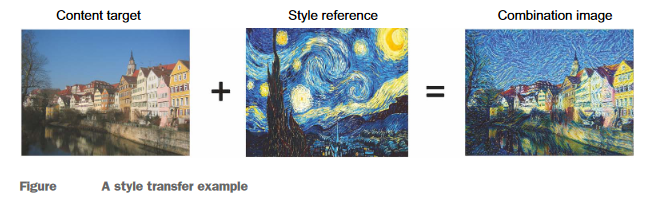

In  this  context,  <font color='blue'>style</font>  essentially  means  <font color='blue'>textures,  colors,  and  visual  patterns</font>  in  the image, at <font color='blue'>various spatial scales</font>, and the <font color='blue'>content</font> is the <font color='blue'>higher-level macrostructure</font> of the  image.  For instance, blue-and-yellow  circular  brushstrokes are  considered  to  be the style in the Figure above (using <font color='blue'>Starry Night</font> by Vincent Van Gogh), and the buildings in the <font color='blue'>Tübingen photograph</font> are considered to be the content.

The idea of <font color='blue'>style transfer</font>, which is tightly <font color='blue'>related</font> to that of <font color='blue'>texture generation</font>, has had  a  long  history  in  the  image-processing  community  prior  to  the  development  of neural style transfer in 2015. But as it turns out, the deep-learning-based implementations of style transfer offer results unparalleled by what had been previously achieved with classical computer vision techniques, and they triggered an amazing <font color='blue'>renaissance</font> in <font color='blue'>creative applications</font> of <font color='blue'>computer vision</font>.

The key notion behind implementing style transfer is the same idea that's <font color='blue'>central</font> to all <font color='blue'>deep learning algorithms</font>: you define a <font color='blue'>loss function</font> to specify what you <font color='blue'>want to achieve</font>, and you <font color='blue'>minimize this loss</font>. We know what we want to achieve: conserving the content of  the <font color='blue'>original  image</font>  while  <font color='blue'>adopting</font>  the  <font color='blue'>style</font>  of  the  <font color='blue'>reference  image</font>.  If  we were able to mathematically define content and style, then an appropriate loss function to minimize would be the following:


$$ \operatorname{loss} = \Big\{\operatorname{dist}\big(\operatorname{style}(\operatorname{reference\_image}) - \operatorname{style}(\operatorname{combination\_image})\big) ~+ \\
\qquad \qquad ~~ \operatorname{dist}\big(\operatorname{content}(\operatorname{original\_image}) - \operatorname{content}(\operatorname{combination\_image})\big)\Big\}$$


Here,  <font color='blue'>distance</font>  is  a  <font color='blue'>norm  function</font>  such  as  the  <font color='blue'>L2  norm</font>,  <font color='blue'>content</font>  is  a  <font color='blue'>function</font>  that <font color='blue'>takes an image</font> and computes a <font color='blue'>representation</font> of its <font color='blue'>content</font>, and <font color='blue'>style</font> is a <font color='blue'>function</font> that  takes  an  image  and  computes  a  representation  of  its  style.  

Minimizing  this  loss causes $\small{\operatorname{style}(\operatorname{combination\_image})}$  to  be  close  to  $\small{\operatorname{style}(\operatorname{reference\_image})}$,  and $\small{\operatorname{content}(\operatorname{combination\_image})}$ is  close  to  $\small{\operatorname{content}(\operatorname{original\_image})}$,  thus  achieving style transfer as we defined it.

A fundamental observation made by Gatys et al. was that <font color='blue'>deep convolutional neural  networks</font>  offer  a  way  to  <font color='blue'>mathematically  define</font>  the  <font color='blue'>style</font>  and  <font color='blue'>content</font>  functions. Let's see how.

### The content loss

As you already know, activations from <font color='blue'>earlier layers</font> in a network contain <font color='blue'>local information</font>  about  the  image,  whereas activations  from  <font color='blue'>higher  layers</font>  contain  increasingly <font color='blue'>global, abstract information</font>. Formulated in a different way, the activations of the <font color='blue'>different layers</font> of a convnet provide a <font color='blue'>decomposition</font> of the <font color='blue'>contents</font> of an <font color='blue'>image</font> over <font color='blue'>different  spatial  scales</font>.  Therefore, you'd  expect  the  content  of  an  image,  which  is more <font color='blue'>global and abstract</font>, to be captured by the representations of the <font color='blue'>upper layers</font> in a convnet.

A good candidate for <font color='blue'>content loss</font> is thus the <font color='blue'>L2 norm</font> between the <font color='blue'>activations</font> of an <font color='blue'>upper layer</font> in a <font color='blue'>pretrained convnet</font>, computed over the target image, and the <font color='blue'>activations</font> of the <font color='blue'>same layer</font> computed over the <font color='blue'>generated image</font>. This guarantees that, as seen from the upper layer, the generated image will look similar to the original target image. Assuming that what the upper layers of a convnet see is really the content of
their input images, this works as a way to preserve image content.

### The style loss

The <font color='blue'>content loss</font> only uses a <font color='blue'>single upper layer</font>, but the <font color='blue'>style loss</font> as defined by Gatys et al. uses <font color='blue'>multiple layers</font> of a convnet: you try to <font color='blue'>capture</font> the appearance of the <font color='blue'>style-reference  image</font>  at  <font color='blue'>all  spatial  scales</font>  extracted  by  the  convnet,  not  just a  single  scale. For the <font color='blue'>style loss</font>, Gatys et al. use the <font color='blue'>Gram matrix</font> of a <font color='blue'>layer's activations</font>: the <font color='blue'>inner product</font> of the <font color='blue'>feature maps</font> of a <font color='blue'>given layer</font>. This inner product can be understood as representing a <font color='blue'>map</font> of the <font color='blue'>correlations</font> between the <font color='blue'>layer's features</font>. These feature correlations  capture  the  <font color='blue'>statistics</font>  of  the  patterns  of  a  particular  spatial  scale, which empirically correspond to the <font color='blue'>appearance</font> of the <font color='blue'>textures</font> found at this scale.

Hence, the <font color='blue'>style loss</font> aims to <font color='blue'>preserve similar internal correlations</font> within the activations of different layers, across the style-reference image and the generated image. In turn,  this  guarantees  that  the  <font color='blue'>textures</font>  found  at  <font color='blue'>different  spatial  scales</font>  look  <font color='blue'>similar</font> across the style-reference image and the generated image.

In short, you can use a <font color='blue'>pretrained convnet</font> to define a <font color='blue'>loss</font> that will do the following:

* <font color='blue'>Preserve content</font> by <font color='blue'>maintaining</font> similar <font color='blue'>high-level layer activations</font> between the original  image  and  the  generated  image.  The  convnet  should  "see"  both  the original image and the generated image as containing the same things.
* <font color='blue'>Preserve style</font> by maintaining <font color='blue'>similar correlations</font> within <font color='blue'>activations</font> for both <font color='blue'>low-level layers</font> and <font color='blue'>high-level layers</font>. Feature correlations capture textures: the generated  image  and  the  style-reference  image  should  share  the  same  textures  at different spatial scales.

Now  let's  look  at  a  <font color='blue'>Keras  implementation</font>  of  the  original  2015  neural  style  transfer algorithm. As you'll see, it shares many similarities with the DeepDream implementation we developed in the previous section.

### Neural style transfer in Keras

Neural  style  transfer  can  be  <font color='blue'>implemented</font>  using  any  <font color='blue'>pretrained  convnet</font>.  Here,  we'll use the <font color='blue'>VGG19 network</font> used by [Gatys et al](https://arxiv.org/pdf/1508.06576.pdf). VGG19 is a variant of the VGG16 network introduced in chapter 5, with three more convolutional layers.

Here's the general process:

*   Set up a <font color='blue'>network</font> that computes <font color='blue'>VGG19 layer activations</font> for the style-reference image, the base image, and the generated image at the same time.
*   Use the <font color='blue'>layer activations</font> computed over these three images to define the <font color='blue'>loss function</font>  described  earlier,  which  we'll  <font color='blue'>minimize</font>  in  order  to  achieve  style transfer.
*   Set up a <font color='blue'>gradient-descent</font> process to minimize this loss function.

Let's start by defining the <font color='blue'>paths</font> to the <font color='blue'>style-reference</font> image and the <font color='blue'>base</font> image. To make  sure  that  the  processed  images  are  a  similar  size  (widely  different  sizes  make style transfer more difficult), we'll later resize them all to a shared height of 400 pixels.



**Getting the style and content images**

In [ ]:
from tensorflow import keras

base_image_path = keras.utils.get_file(                                         # Path to the image we want to transform.
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(                              # Path to the style image.
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size    # Dimensions of the generated picture.
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 1s 1us/step


Our content and style images are shown below.

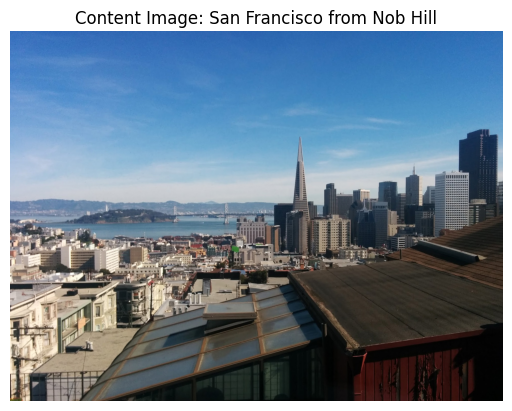

In [ ]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.title('Content Image: San Francisco from Nob Hill')
plt.imshow(keras.utils.load_img(base_image_path))

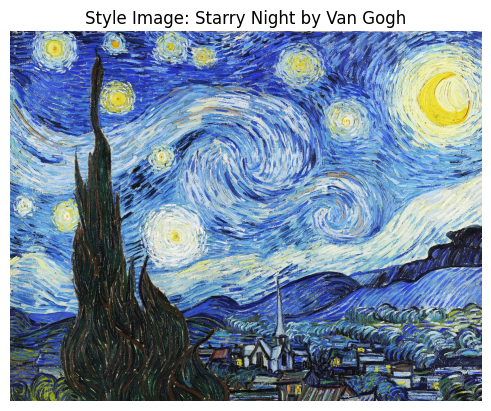

In [ ]:
plt.axis("off")
plt.title('Style Image: Starry Night by Van Gogh')
plt.imshow(keras.utils.load_img(style_reference_image_path))

**Auxiliary functions**

We also need some <font color='blue'>auxiliary functions</font> for loading, preprocessing, and postprocessing the images that go in and out of the VGG19 convnet.

In [ ]:
import numpy as np

def preprocess_image(image_path):                                               # Util function to open, resize, and format pictures into appropriate arrays.
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):                                                       # Util function to convert a NumPy array into a valid image.
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                                                     # Zero-centering by removing the mean pixel value from ImageNet.
    img[:, :, 1] += 116.779                                                     # This reverses a transformation done by vgg19.preprocess_input.
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]                                                       # Converts images from ’BGR’ to ’RGB’. This is also part of the reversal of vgg19.preprocess_input.

    img = np.clip(img, 0, 255).astype("uint8")                                  # Limit the values in the array from 0 to 255.
    return img

Let's set up the VGG19 network. Like in the <font color='blue'>DeepDream</font> example, we'll use the <font color='blue'>pretrained convnet</font> to create a <font color='blue'>feature exactor model</font> that returns the activations of intermediate layers—all layers in the model this time.

**Using a pretrained VGG19 model to create a feature extractor**

In [ ]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)   # Build a VGG19 model loaded with pretrained ImageNet weights.

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)      # Model that returns the activation values for every target layer (as a dict).

80134624/80134624 [==============================] - 1s 0us/step


Let's define the <font color='blue'>content loss</font>, which will make sure the top layer of the VGG19 convnet has a <font color='blue'>similar view</font> of the <font color='blue'>style</font> image and the <font color='blue'>combination</font> image.

**Content loss**

In [ ]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

Next is the <font color='blue'>style loss</font>. It uses an auxiliary function to compute the <font color='blue'>Gram matrix</font> of an input matrix: a map of the correlations found in the original feature matrix.

**Style loss**

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

To these <font color='blue'>two loss components</font>, you add a third: the <font color='blue'>total variation loss</font>, which operates on the pixels of the generated combination image. It encourages spatial continuity in the generated image, thus avoiding overly pixelated results. You can interpret it as a regularization loss.

**Total variation loss**

In [ ]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

The loss that you minimize is a <font color='blue'>weighted average</font> of these <font color='blue'>three losses</font>. To compute the content loss, you use only one upper layer—the `block5_conv2` layer—whereas for the style loss, you use a list of layers that spans both low-level and high-level layers. You add the total variation loss at the end.

Depending  on  the  style-reference  image  and  content  image  you're  using,  you'll likely  want  to  tune  the <font color='blue'>content_weight coefficient</font>  (the  contribution  of  the  content loss to the total loss). A higher <font color='blue'>content_weight</font> means the target content will be more recognizable in the generated image.

**Defining the final loss that you'll minimize**

In [ ]:
style_layer_names = [                                                           # List of layers to use for the style loss.
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"                                             # The layer to use for the content loss.
total_variation_weight = 1e-6                                                   # Contribution weight of the total variation loss.
style_weight = 1e-6                                                             # Contribution weight of the style loss.
content_weight = 2.5e-8                                                         # Contribution weight of the content loss.

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())                                                   # Initialize the loss to 0.
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(                                # Add the content loss.
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value      # Add the style loss.

    loss += total_variation_weight * total_variation_loss(combination_image)    # Add the total variation loss.
    return loss

Finally, let's set up the <font color='blue'>gradient-descent process</font>. In the original Gatys et al. paper, optimization is performed using the <font color='blue'>LBFGS algorithm</font>, but that's <font color='blue'>not available</font> in <font color='blue'>TensorFlow</font>, so we'll just do <font color='blue'>mini-batch gradient descent</font> with the <font color='blue'>SGD optimizer</font> instead. We'll leverage an optimizer feature you haven't seen before: a <font color='blue'>learning-rate schedule</font>. We'll use it to gradually decrease the learning rate from a very high value (100) to a much smaller final value (about 20). That way, we'll make fast progress in the early stages of training and then proceed more cautiously as we get closer to the loss minimum.

**Setting up the gradient-descent process**

In [ ]:
import tensorflow as tf

@tf.function                                                                    # We make the training step fast by compiling it as a tf.function.
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96           # We’ll start with a learning rate of 100 and decrease it by 4%
    )                                                                           # every 100 steps.
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))              # Use a Variable to store the combination image since we’ll be updating it during training.

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])                     # Update the combination image in a direction that reduces the style transfer loss.
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)                                        # Save the combination image at regular intervals.

Iteration 100: loss=8138.23
Iteration 200: loss=6652.13
Iteration 300: loss=6062.29
Iteration 400: loss=5741.50
Iteration 500: loss=5534.86
Iteration 600: loss=5389.25
Iteration 700: loss=5280.12
Iteration 800: loss=5194.52
Iteration 900: loss=5125.39
Iteration 1000: loss=5068.50
Iteration 1100: loss=5020.74
Iteration 1200: loss=4979.91
Iteration 1300: loss=4944.57
Iteration 1400: loss=4913.63
Iteration 1500: loss=4886.36
Iteration 1600: loss=4862.18
Iteration 1700: loss=4840.60
Iteration 1800: loss=4821.25
Iteration 1900: loss=4803.81
Iteration 2000: loss=4788.02
Iteration 2100: loss=4773.65
Iteration 2200: loss=4760.54
Iteration 2300: loss=4748.47
Iteration 2400: loss=4737.38
Iteration 2500: loss=4727.17
Iteration 2600: loss=4717.71
Iteration 2700: loss=4708.95
Iteration 2800: loss=4700.81
Iteration 2900: loss=4693.23
Iteration 3000: loss=4686.18
Iteration 3100: loss=4679.57
Iteration 3200: loss=4673.36
Iteration 3300: loss=4667.55
Iteration 3400: loss=4662.11
Iteration 3500: loss=46

The Figure below shows  what  you  get.  Keep  in  mind  that  what  this  technique  achieves  is merely a form of <font color='blue'>image retexturing</font>, or <font color='blue'>texture transfer</font>. It works best with <font color='blue'>style-reference images</font> that are <font color='blue'>strongly textured</font> and <font color='blue'>highly self-similar</font>, and with content targets that don't require high levels of detail in order to be recognizable. It typically can't achieve fairly abstract feats such as transferring the style of one portrait to another. The algorithm is closer to classical signal processing than to AI, so don't expect it to work like magic.

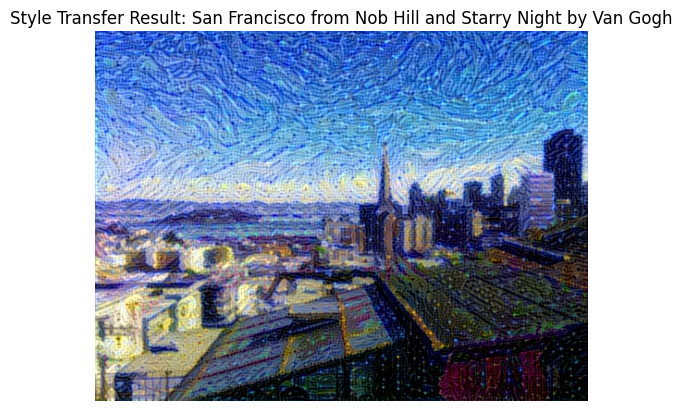

In [ ]:
plt.axis("off")
plt.title('Style Transfer Result: San Francisco from Nob Hill and Starry Night by Van Gogh')
plt.imshow(keras.utils.load_img(fname))

Additionally, note that this style-transfer algorithm is <font color='blue'>slow to run</font>. But the transformation  operated  by  the  setup  is  simple  enough  that  it  can  be  learned  by  a  <font color='blue'>small,  fast feedforward convnet</font> as well—as long as you have appropriate training data available. Fast  style  transfer  can  thus  be  achieved  by  first  spending  a  <font color='blue'>lot  of  compute  cycles</font>  to generate <font color='blue'>input-output  training  examples</font>  for a fixed style-reference image, using  the
method outlined here, and then training a simple convnet to learn this style-specific transformation. Once that's done, stylizing a given image  is instantaneous: it's just a forward pass of this small convnet.

### Wrapping up


*   <font color='blue'>Style transfer</font> consists of creating a new image that <font color='blue'>preserves</font> the contents of a <font color='blue'>target</font> image while also capturing the <font color='blue'>style</font> of a <font color='blue'>reference image</font>.
*   <font color='blue'>Content</font> can be captured by the <font color='blue'>high-level activations</font> of a convnet.
*   <font color='blue'>Style</font> can be captured by the <font color='blue'>internal correlations</font> of the activations of different layers of a convnet.
*   Hence, deep learning allows <font color='blue'>style transfer</font> to be formulated as an <font color='blue'>optimization process</font> using a loss defined with a pretrained convnet.
*   Starting from this basic idea, <font color='blue'>many variants</font> and <font color='blue'>refinements</font> are possible.


### Further Information

A very nice blog post titled [Building Style Transfer Algorithms using the VGG-19 Neural Network](https://philippeheitzmann.com/2022/01/implementing-vgg19-and-custom-built-style-transfer-algorithms-to-artificially-stylize-images/) shows a lot of interesting examples for the VGG-19 Neural Network. Its corresponding Github repository is [here](https://github.com/philippe-heitzmann/Neural_Style_Transfer_VGG19).